In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

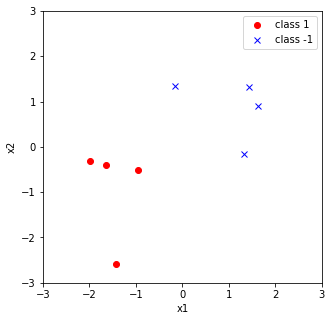

In [2]:
# Generate data
np.random.seed(4)
N = 4
dim = 2
X1 = np.random.normal(-1, 1, (N, dim))
X2 = np.random.normal(1, 1, (N, dim))
X = np.concatenate((X1, X2), axis=0)
y = np.array([1, 1, 1, 1, -1, -1, -1, -1])

# Plot data
plt.figure(figsize=(5, 5))
plt.plot(X[y == 1, 0], X[y == 1, 1], 'ro', label='class 1')
plt.plot(X[y == -1, 0], X[y == -1, 1], 'bx', label='class -1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.savefig('plots/gp_classification_data.png', facecolor='white')

In [3]:
# Binary Laplace Gaussian Process Classification

# Define kernel function (RBF)
def kernel(x1, x2):
    return np.exp(-np.sum((x1 - x2)**2))

In [4]:
# covariance matrix
K = np.array([[kernel(X[i], X[j]) for j in range(2*N)] for i in range(2*N)])

# logistic Likelihood
def loglik(y, f):
    return np.sum(np.log(1 + np.exp(-y*f)))

In [5]:
# Laplace approximation
from scipy.integrate import quad

def laplace_approximation(y, K, X, x_new=None, max_iter=100):
    N = len(y)
    f = np.zeros(N)
    for i in range(max_iter):
        pi = np.exp(f) / (1 + np.exp(f))
        W = np.diag(pi * (1 - pi))
        W_sqrt = np.sqrt(W)
        L = np.linalg.cholesky(np.eye(N) + W_sqrt.dot(K).dot(W_sqrt)) # Cholesky decomposition
        t = (y + np.ones(N)) / 2 - pi
        b = W.dot(f) + t
        a = b - W_sqrt.dot(np.linalg.solve(L.T, np.linalg.solve(L, W_sqrt.dot(K).dot(b))))
        f = K.dot(a)

    pi = np.exp(f) / (1 + np.exp(f))
    W = np.diag(pi * (1 - pi))
    W_sqrt = np.sqrt(W)
    L = np.linalg.cholesky(np.eye(N) + W_sqrt.dot(K).dot(W_sqrt))
    t = (y + np.ones(N)) / 2 - pi
    b = W.dot(f) + t
    a = b - W_sqrt.dot(np.linalg.solve(L.T, np.linalg.solve(L, W_sqrt.dot(K).dot(b))))

    # approximate marginal log likelihood
    def q(y, X):
        return -0.5 * a.T.dot(f) + loglik(y, f) - np.sum(np.log(np.diag(L)))

    if x_new is None:
        return f, q, pi
    
    else: 
        # predictive mean
        k_new = np.array([kernel(x_new, X[i]) for i in range(len(X))])
        f_new = k_new.dot(t)
        # predictive variance
        v = np.linalg.solve(L, W_sqrt.dot(k_new))
        v_new = np.array(kernel(x_new, x_new)) - v.dot(v)
        # predictive class probability
        def integrand(z):
            return 1 / (1 + np.exp(-z)) * multivariate_normal(mean = f_new, cov = v_new).pdf(z)
        pi_new = quad(integrand, -100, 100)[0]

        return f_new, pi_new

In [6]:
# Result
f, q, pi = laplace_approximation(y, K, X)
print('f =', f)
print('pi =', pi)

f = [ 0.63518684  0.71196897  0.40703099  0.80890706 -0.51268413 -0.72487512
 -0.67468816 -0.42943816]
pi = [0.65366463 0.67083608 0.60037575 0.69187656 0.37456451 0.32632035
 0.33744788 0.3942605 ]


In [7]:
# predictive distribution
from tqdm import tqdm

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X_new = np.array([X1, X2]).reshape(2, -1).T
pis = np.zeros(len(X_new))
for i in tqdm(range(len(X_new))):
    f_new, pi_new = laplace_approximation(y, K, X, x_new = X_new[i])
    pis[i] = pi_new

  0%|          | 0/10000 [00:00<?, ?it/s]

 14%|█▍        | 1407/10000 [00:40<04:09, 34.42it/s]


KeyboardInterrupt: 

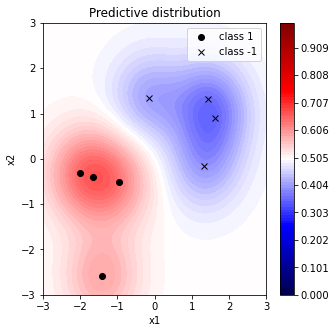

In [ ]:
# Plot
pis = pis.reshape(100, 100)
plt.figure(figsize=(5, 5))
plt.contourf(X1, X2, pis, levels=np.linspace(0, 1, 100), cmap='seismic')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'ko', label='class 1')
plt.plot(X[y == -1, 0], X[y == -1, 1], 'kx', label='class -1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.colorbar()
plt.title('Predictive distribution')
plt.savefig('plots/GP_classification.png', facecolor='white')

In [13]:
# Use GPy

import GPy

kenrel = GPy.kern.RBF(input_dim=2, variance=1, lengthscale=1)
la = GPy.inference.latent_function_inference.Laplace()

gpc = GPy.models.GPClassification(X, y.reshape(-1, 1), kernel=kenrel, inference_method=la)
gpc.optimize(messages=True)

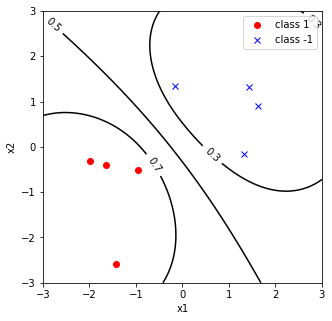

In [20]:
pis = gpc.predict(X_new)[0].reshape(100, 100)

# Plot

plt.figure(figsize=(5, 5))
CP = plt.contour(X1, X2, pis, levels=[0.3, 0.5, 0.7], colors='k')
plt.clabel(CP, inline=1, fontsize=10)
plt.plot(X[y == 1, 0], X[y == 1, 1], 'ro', label='class 1')
plt.plot(X[y == -1, 0], X[y == -1, 1], 'bx', label='class -1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()
